## A* Search — Class-based

## Imports & simple heuristic

In [16]:
import heapq
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Optional, Dict, Any

# Type alias for position (row, col)
Pos = Tuple[int, int]

### Heuristic Function

In [17]:
def manhattan(a: Pos, b: Pos) -> int:
    """Compute Manhattan distance between two positions (row, col)."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

## Maze class

In [18]:
class Maze:
    def __init__(self, grid: List[List[Any]]):
        """
        Maze object from 2D list.
        'A' = start, 'B' = goal, 0 = free, 1 = wall
        """
        self.raw = grid
        self.rows = len(grid)
        self.cols = len(grid[0]) if self.rows > 0 else 0
        self.grid = np.zeros((self.rows, self.cols), dtype=int)
        self.start: Optional[Pos] = None
        self.goal: Optional[Pos] = None

        # Parse grid
        for i in range(self.rows):
            for j in range(self.cols):
                val = grid[i][j]
                if val == 'A':
                    self.start = (i, j)
                    self.grid[i, j] = 0
                elif val == 'B':
                    self.goal = (i, j)
                    self.grid[i, j] = 0
                else:
                    # assume numeric 0/1 (or convertible)
                    self.grid[i, j] = int(val)

    def in_bounds(self, pos: Pos) -> bool:
        """Check if position is inside maze bounds."""
        r, c = pos
        return 0 <= r < self.rows and 0 <= c < self.cols

    def is_free(self, pos: Pos) -> bool:
        """Check if position is free (not wall)."""
        return self.grid[pos] == 0

    def get_neighbors(self, pos: Pos) -> List[Pos]:
        """Return valid 4-directional neighbors."""
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        result = []
        for dr, dc in directions:
            n = (pos[0] + dr, pos[1] + dc)
            if self.in_bounds(n) and self.is_free(n):
                result.append(n)
        return result

    def visualize(self, path: Optional[List[Pos]] = None, show: bool = True, title: str = "A* Search"):
        """Visualize maze with optional path overlay."""
        plt.figure(figsize=(7, 7))
        plt.imshow(self.grid, cmap="binary")
        plt.xticks(range(self.cols))
        plt.yticks(range(self.rows))
        plt.grid(True)

        if path:
            px, py = zip(*path)
            plt.plot(py, px, marker="o", color="red", linewidth=2)

        if self.start:
            plt.scatter(self.start[1], self.start[0], c="green", s=100, label="Start (A)")
        if self.goal:
            plt.scatter(self.goal[1], self.goal[0], c="blue", s=100, label="Goal (B)")

        plt.legend()
        plt.title(title)
        if show:
            plt.show()

## A* class

In [19]:
class AStar:
    def __init__(self, maze: Maze, heuristic=manhattan):
        """
        Initialize A* with a given maze object.
        """
        self.maze = maze
        self.heuristic = heuristic
        self.reset_state()

    def reset_state(self):
        """Reset all A* search data structures."""
        self.open_heap = []         # priority queue (f, counter, node)
        self.came_from = {}         # path reconstruction
        self.g_score = {}           # cost from start
        self.f_score = {}           # estimated total cost
        self.closed_set = set()     # already expanded nodes
        self._counter = 0           # tie-breaking counter

    def reconstruct_path(self, current: Pos) -> List[Pos]:
        """Reconstruct path from start to current using came_from."""
        path = []
        while current in self.came_from:
            path.append(current)
            current = self.came_from[current]
        path.append(current)  # add start node
        return path[::-1]     # reverse for correct order

    def search(self, start: Optional[Pos] = None, goal: Optional[Pos] = None, verbose: bool = False):
        """
        Run the A* search.
        Returns:
            path (list of nodes) OR (path, steps_log) if verbose=True
        """
        if start is None:
            start = self.maze.start
        if goal is None:
            goal = self.maze.goal
        if start is None or goal is None:
            raise ValueError("Start and goal must be provided (either in maze or as arguments).")

        # reset algorithm state
        self.reset_state()

        # initialize scores
        self.g_score[start] = 0
        self.f_score[start] = self.heuristic(start, goal)
        heapq.heappush(self.open_heap, (self.f_score[start], self._counter, start))
        self._counter += 1

        steps_log = [] if verbose else None

        # main loop
        while self.open_heap:
            f, _, current = heapq.heappop(self.open_heap)

            # skip if already closed (duplicate in heap)
            if current in self.closed_set:
                if verbose:
                    steps_log.append({"action": "skip_closed", "pos": current})
                continue

            # mark as expanded
            self.closed_set.add(current)
            if verbose:
                steps_log.append({"action": "expand", "pos": current, "f": f, "g": self.g_score.get(current)})

            # check goal
            if current == goal:
                path = self.reconstruct_path(current)
                if verbose:
                    steps_log.append({"action": "found_goal", "path_length": len(path)})
                    return path, steps_log
                return path

            # explore neighbors
            for neighbor in self.maze.get_neighbors(current):
                if neighbor in self.closed_set:
                    continue

                tentative_g = self.g_score[current] + 1  # uniform cost per step

                if neighbor not in self.g_score or tentative_g < self.g_score[neighbor]:
                    # better path found
                    self.came_from[neighbor] = current
                    self.g_score[neighbor] = tentative_g
                    self.f_score[neighbor] = tentative_g + self.heuristic(neighbor, goal)
                    heapq.heappush(self.open_heap, (self.f_score[neighbor], self._counter, neighbor))
                    self._counter += 1

                    if verbose:
                        steps_log.append({
                            "action": "push_open",
                            "pos": neighbor,
                            "g": tentative_g,
                            "f": self.f_score[neighbor],
                            "from": current,
                        })

        # no path found
        if verbose:
            steps_log.append({"action": "no_path"})
            return None, steps_log
        return None

## Small helper function to print path

In [20]:
def print_steps(steps_log: List[Dict], max_lines: int = 100) -> None:
    """Pretty-print the verbose steps from A* search."""
    if not steps_log:
        print("(no steps logged)")
        return

    for i, ev in enumerate(steps_log[:max_lines], 1):
        action = ev.get("action")
        if action == "expand":
            print(f"{i:03d}. Expand: {ev['pos']} g={ev.get('g')} f={ev.get('f')}")
        elif action == "push_open":
            print(f"{i:03d}. Push open: {ev['pos']} from={ev.get('from')} g={ev.get('g')} f={ev.get('f')}")
        elif action == "found_goal":
            print(f"{i:03d}. Goal found! path_length={ev.get('path_length')}")
        elif action == "no_path":
            print(f"{i:03d}. No path found")
        elif action == "skip_closed":
            print(f"{i:03d}. Skip (already closed): {ev.get('pos')}")
        else:
            print(f"{i:03d}. {ev}")

    if len(steps_log) > max_lines:
        print(f"... ({len(steps_log) - max_lines} more steps not shown)")


## Example maze and run

Maze: 12 rows x 12 cols
Start = (0, 0), Goal = (11, 11)

Path found: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (11, 11)]

First 40 log lines:
001. Expand: (0, 0) g=0 f=22
002. Push open: (0, 1) from=(0, 0) g=1 f=22
003. Push open: (1, 0) from=(0, 0) g=1 f=22
004. Expand: (0, 1) g=1 f=22
005. Push open: (1, 1) from=(0, 1) g=2 f=22
006. Expand: (1, 0) g=1 f=22
007. Expand: (1, 1) g=2 f=22
008. Push open: (2, 1) from=(1, 1) g=3 f=22
009. Expand: (2, 1) g=3 f=22
010. Push open: (2, 2) from=(2, 1) g=4 f=22
011. Expand: (2, 2) g=4 f=22
012. Push open: (2, 3) from=(2, 2) g=5 f=22
013. Expand: (2, 3) g=5 f=22
014. Push open: (3, 3) from=(2, 3) g=6 f=22
015. Push open: (1, 3) from=(2, 3) g=6 f=24
016. Expand: (3, 3) g=6 f=22
017. Push open: (3, 4) from=(3, 3) g=7 f=22
018. Push open: (4, 3) from=(3, 3) g=7 f=22
019. Expand: (3, 4) g=7 f=22
0

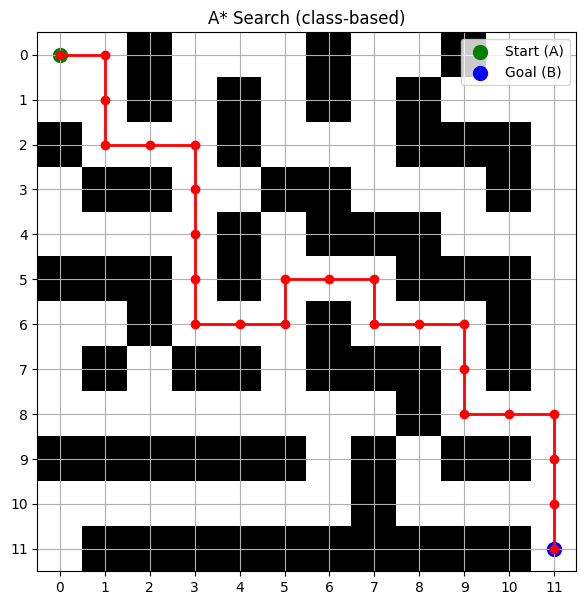

In [21]:
maze5 = [
    ['A', 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
    [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 'B'],
]

# Create maze object
m = Maze(maze5)
print(f"Maze: {m.rows} rows x {m.cols} cols")
print(f"Start = {m.start}, Goal = {m.goal}")

# Run A* search
astar = AStar(m, heuristic=manhattan)
path, log = astar.search(verbose=True)  # verbose -> get trace

print("\nPath found:", path)
print("\nFirst 40 log lines:")
print_steps(log, max_lines=40)

# Visualize path
m.visualize(path=path, title="A* Search (class-based)")

## Step-by-step Animation (Pathfinding Process)

In [23]:
import matplotlib.animation as animation
from IPython.display import HTML

def animate_astar(maze: Maze, astar: AStar, interval=300):
    # Run search with verbose logging
    path, log = astar.search(verbose=True)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(maze.grid, cmap="binary")
    ax.set_xticks(range(maze.cols))
    ax.set_yticks(range(maze.rows))
    ax.grid(True)

    # Mark start and goal
    ax.scatter(maze.start[1], maze.start[0], color="green", s=100, label="Start")
    ax.scatter(maze.goal[1], maze.goal[0], color="blue", s=100, label="Goal")

    # Dynamic objects
    expanded = ax.scatter([], [], color="orange", s=40, label="Expanded")
    frontier = ax.scatter([], [], color="purple", s=40, label="Frontier")
    line_path, = ax.plot([], [], color="red", linewidth=2, label="Path")

    expanded_nodes = []
    frontier_nodes = []
    path_nodes = []

    def update(frame):
        nonlocal path_nodes  # needed to modify path_nodes

        ev = log[frame]

        if ev["action"] == "expand":
            expanded_nodes.append(ev["pos"])
        elif ev["action"] == "push_open":
            frontier_nodes.append(ev["pos"])
        elif ev["action"] == "found_goal":
            path_nodes = path  # assign final path

        # Update expanded + frontier nodes
        if expanded_nodes:
            ex_x, ex_y = zip(*expanded_nodes)
            expanded.set_offsets(list(zip(ex_y, ex_x)))
        if frontier_nodes:
            fr_x, fr_y = zip(*frontier_nodes)
            frontier.set_offsets(list(zip(fr_y, fr_x)))

        # Draw path if available
        if path_nodes:
            px, py = zip(*path_nodes)
            line_path.set_data(py, px)

        return expanded, frontier, line_path

    ani = animation.FuncAnimation(
        fig, update, frames=len(log), interval=interval,
        blit=False, repeat=False
    )
    plt.close(fig)
    return HTML(ani.to_jshtml())


# Example run (on maze5 from earlier)
astar = AStar(m)
animate_astar(m, astar)
